In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
model = load_model('/scratch/users/ashdef/model_out/6month_v3/baseline.keras')

2025-12-04 09:08:07.442333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/software/user/open/cudnn/8.1.1.33/lib64:/share/software/user/open/nccl/2.8.4/lib:/usr/lib64/nvidia:/share/software/user/open/cuda/11.2.0/targets/x86_64-linux/lib:/share/software/user/open/cuda/11.2.0/lib64:/share/software/user/open/cuda/11.2.0/nvvm/lib64:/share/software/user/open/cuda/11.2.0/extras/Debugger/lib64:/share/software/user/open/cuda/11.2.0/extras/CUPTI/lib64:/share/software/user/open/openblas/0.3.10/lib:/share/software/user/open/harfbuzz/1.4.8/lib:/share/software/user/open/icu/59.1/lib:/share/software/user/open/cairo/1.14.10/lib:/share/software/user/open/gobject-introspection/1.52.1/lib:/share/software/user/open/fontconfig/2.12.4/lib:/share/software/user/open/x11/7.7/lib:/share/software/user/open/libxkbcommon/0.9.1/lib64:/share/softwa

In [2]:
sfe_post = np.load("/scratch/users/ashdef/post_treatment_data/no_nans/sfe_filtered_window.npz", allow_pickle = True)["sfe_window"] 
climate_post = np.load("/scratch/users/ashdef/post_treatment_data/no_nans/climate_filtered_window.npz", allow_pickle = True)["climate_window"]

## scaling

In [4]:
print(sfe_post.shape)
print(climate_post.shape)

(1713181,)
(1713181, 6, 8)


In [3]:
sfe_post_rs = sfe_post.reshape(-1,1) # single feature
sfe_post_rs.shape


(1713181, 1)

In [6]:
# climate data is 3d, needs to be 2d for minmaxscaler
# so reshape and then turn back to original shape after processing
climate_post_ogshape = climate_post.shape
print(climate_post_ogshape)

climate_post_rs = climate_post.reshape(-1, climate_post_ogshape[2]) # (pixel-month pairs * timesteps, 8)
climate_post_rs.shape

(1713181, 6, 8)


(10279086, 8)

In [7]:
scaler_sfe = MinMaxScaler(feature_range=(0,1))
scaler_climate = MinMaxScaler(feature_range=(0,1))

sfe_post_scaled = scaler_sfe.fit_transform(sfe_post_rs)
climate_post_scaled = scaler_climate.fit_transform(climate_post_rs)



In [8]:
print(sfe_post_scaled.min(), sfe_post_scaled.max())
print(climate_post_scaled.min(), climate_post_scaled.max())


0.0 1.0
0.0 1.0000000000000004


In [9]:
sfe_back = scaler_sfe.inverse_transform(sfe_post_scaled)

sfe_back.shape
print(sfe_back.min(), sfe_back.max())
print(sfe_post_rs.min(), sfe_post_rs.max())


-0.3997638117016128 5.0895903135598495
-0.39976381170161285 5.08959031355985


In [10]:
# change climate data back to orig shape
climate_post_scaled = climate_post_scaled.reshape(climate_post_ogshape)

In [11]:
climate_post_scaled = np.array(climate_post_scaled)
sfe_post_scaled = np.array(sfe_post_scaled)

# wrap the lists as object arrays - allows arrays of different lengths to be saved
sfe_obj = np.array(sfe_post_scaled, dtype=object)
climate_obj = np.array(climate_post_scaled, dtype=object)

In [12]:
np.savez_compressed("/scratch/users/ashdef/post_treatment_data/no_nans/sfe_window_scaled.npz", sfe_post = sfe_obj)
np.savez_compressed("/scratch/users/ashdef/post_treatment_data/no_nans/climate_window_scaled.npz", climate_post =climate_obj)

## use the model to predict post treatment et based off of climate data

In [13]:
post_trmt_preds = model.predict(climate_post_scaled)

53537/53537 [==============================] - 67s 1ms/step


In [16]:
post_trmt_preds.shape

(1713181, 1)

In [17]:
np.save("/scratch/users/ashdef/model_out/6month_v3/post_treatment/predictions_scaled.npy", post_trmt_preds)

predictions_original = scaler_sfe.inverse_transform(post_trmt_preds)
np.save("/scratch/users/ashdef/model_out/6month_v3/post_treatment/predictions_original_scale.npy", predictions_original)


### calculate post treatment anamolies for every pixel-month pair

In [4]:
predictions_original = np.load("/scratch/users/ashdef/model_out/6month_v3/post_treatment/predictions_original_scale.npy")

In [5]:
predictions_original.shape

(1713181, 1)

In [6]:
predictions_original = predictions_original.flatten()
predictions_original.shape

(1713181,)

In [7]:
sfe_post_rs.shape

(1713181, 1)

In [8]:
sfe_post_rs = sfe_post_rs.flatten()
sfe_post_rs.shape

(1713181,)

In [9]:
anamoly = sfe_post_rs - predictions_original

In [10]:
anamoly.shape

(1713181,)

In [11]:
print(anamoly.mean())
print(anamoly.max())
print(anamoly.min())

0.04394425848127624
2.0595685772317527
-1.5624339223968973


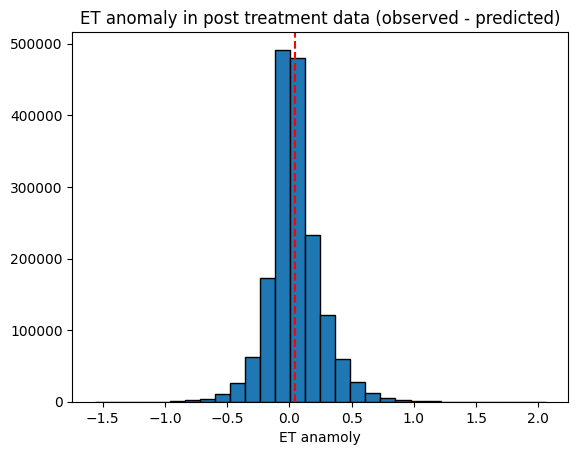

In [12]:
plt.hist(anamoly, bins=30, edgecolor = 'black')
plt.xlabel('ET anamoly')
plt.axvline(anamoly.mean(), color = 'red', linestyle = '--')
plt.title('ET anomaly in post treatment data (observed - predicted)')
plt.show()

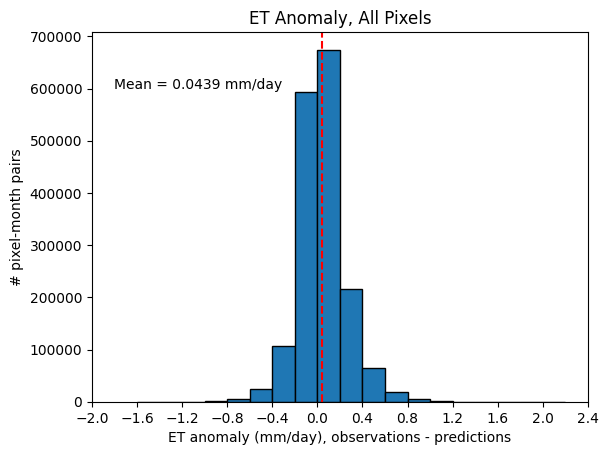

In [13]:
bin_width = 0.2  
bins = np.arange(anamoly.min() - (anamoly.min() % bin_width),
                 anamoly.max() + bin_width,
                 bin_width)

plt.hist(anamoly, bins=bins, edgecolor='black')

#help from chatgpt for setting x ticks to line up with bars 
xmin, xmax = plt.xlim()
xticks = np.arange(np.floor(xmin / 0.4) * 0.4,
                   np.ceil(xmax / 0.4) * 0.4 + 0.001,
                   0.4)
plt.xticks(xticks)
plt.text(-1.8,600000, f'Mean = {np.round(anamoly.mean(),4)} mm/day')

plt.xlabel('ET anomaly (mm/day), observations - predictions')
plt.ylabel('# pixel-month pairs')
plt.axvline(anamoly.mean(), color='red', linestyle='--')
plt.title('ET Anomaly, All Pixels')
plt.show()

### put pixel-month pairs back into pixel sequences, taking into account sliding windows which cause some timesteps to be skipped in prediction

In [14]:
sfe_no_window = np.load("/scratch/users/ashdef/post_treatment_data/no_nans/sfe_post_arrays.npz", allow_pickle = True)["sfe_pre"] 

In [15]:
sfe_no_window.shape

(11465,)

In [16]:
predictions_original = np.load("/scratch/users/ashdef/model_out/6month_v3/post_treatment/predictions_original_scale.npy")

In [17]:
window_size = 6  # same as used in building sliding window arrays used as input

# how many predictions (windows) each pixel produced
pixel_num_predictions = [len(arr) - window_size for arr in sfe_no_window]

# slice predictions and original sfe based on those counts
prediction_arrays = []
sfe_arrays = []

idx = 0
for count in pixel_num_predictions:
    prediction_arrays.append(predictions_original[idx:idx + count])
    sfe_arrays.append(sfe_post[idx:idx+count]) # putting pixel-month pairs back to pixel sequences, but taking into account windows
    idx += count

In [18]:
print(sfe_arrays[11464].shape)
prediction_arrays[11464].shape # last pixels only produced 5 predictions since it needed previous 6 pixels (window size) to inform those prediction

(5,)


(5, 1)

In [19]:
predictions_obj = np.array(prediction_arrays, dtype = object)
sfe_obj = np.array(sfe_arrays, dtype = object)
np.savez_compressed("/scratch/users/ashdef/model_out/6month_v3/post_treatment/prediction_arrays.npz", preds = predictions_obj)
np.savez_compressed("/scratch/users/ashdef/model_out/6month_v3/post_treatment/sfe_arrays.npz", sfe = sfe_obj)

In [20]:
sfe_arrays = np.load("/scratch/users/ashdef/model_out/6month_v3/post_treatment/sfe_arrays.npz", allow_pickle = True)['sfe']
prediction_arrays = np.load("/scratch/users/ashdef/model_out/6month_v3/post_treatment/prediction_arrays.npz", allow_pickle = True)['preds']

In [21]:
sfe_arrays.shape

(11465,)

In [22]:
sfe_arrays_no2023 = []
pred_arrays_no2023 = []
for pixel in range(len(sfe_arrays)):
    if len(sfe_arrays[pixel]) > 5:
        sfe_arrays_no2023.append(sfe_arrays[pixel])
        pred_arrays_no2023.append(prediction_arrays[pixel])

In [48]:
len(sfe_arrays_no2023)

10597

In [49]:
# pixel month pairs
sfe_no2023_pm = []
preds_no2023_pm = []

for pixel in range(len(sfe_arrays_no2023)):
    for t in range(len(sfe_arrays_no2023[pixel])):
        sfe_no2023_pm.append(sfe_arrays_no2023[pixel][t])
        preds_no2023_pm.append(pred_arrays_no2023[pixel][t])

In [50]:
predictions_obj = np.array(preds_no2023_pm, dtype = object)
sfe_obj = np.array(sfe_no2023_pm, dtype = object)
np.savez_compressed("/scratch/users/ashdef/model_out/6month_v3/post_treatment/preds_no2023_pm.npz", preds = predictions_obj)
np.savez_compressed("/scratch/users/ashdef/model_out/6month_v3/post_treatment/sfe_no2023_pm.npz", sfe = sfe_obj)

In [51]:
preds_no2023_pm = np.load('/scratch/users/ashdef/model_out/6month_v3/post_treatment/preds_no2023_pm.npz', allow_pickle = True)["preds"]
sfe_no2023_pm = np.load('/scratch/users/ashdef/model_out/6month_v3/post_treatment/sfe_no2023_pm.npz', allow_pickle = True)["sfe"]

In [52]:
sfe_no2023_pm = sfe_no2023_pm.flatten()
sfe_no2023_pm.shape

(1708841,)

In [53]:
preds_no2023_pm = preds_no2023_pm.flatten()
preds_no2023_pm.shape

(1708841,)

In [54]:
anomaly_no2023 = sfe_no2023_pm - preds_no2023_pm
anomaly_no2023.shape

(1708841,)

In [55]:
np.asarray(anomaly_no2023, dtype=np.float64)

array([-0.18758772, -0.0482482 ,  0.00694902, ...,  0.00682029,
        0.01539042, -0.01854801])

In [56]:
anomaly_no2023.mean()

0.044003446581004906

In [57]:
pixel_treatment_g75_cover = pd.read_csv('/scratch/users/ashdef/post_treatment_data/no_nans/pixel_treatment_g75_cover.csv')
pixel_treatment_g75_cover = pixel_treatment_g75_cover.set_index(['Unnamed: 0'])

In [58]:
sfe_arrays = np.load("/scratch/users/ashdef/model_out/6month_v3/post_treatment/sfe_arrays.npz", allow_pickle = True)["sfe"]

In [59]:
sfe_g75_arrays = sfe_arrays[pixel_treatment_g75_cover.index]


In [60]:
len(sfe_g75_arrays)

193

In [61]:
prediction_arrays = np.load("/scratch/users/ashdef/model_out/6month_v3/post_treatment/prediction_arrays.npz", allow_pickle = True)["preds"]

In [62]:
prediction_arrays.shape

(11465,)

In [63]:
preds_g75_arrays = prediction_arrays[pixel_treatment_g75_cover.index]
len(preds_g75_arrays)

193

In [64]:
sfe_g75 = sfe_g75_arrays.reshape(-1)
preds_g75 = preds_g75_arrays.reshape(-1)
sfe_g75.shape

(193,)

In [65]:
print(len(sfe_g75[0]))
len(preds_g75[0])

413


413

In [66]:
# pixel month pairs
sfe_g75_pm = []
preds_g75_pm = []

for pixel in range(len(sfe_g75)):
    for t in range(len(sfe_g75[pixel])):
        if len(sfe_g75[pixel]) >5:
            sfe_g75_pm.append(sfe_g75[pixel][t])
            preds_g75_pm.append(preds_g75[pixel][t])

In [67]:
sfe_g75_pm = np.array(sfe_g75_pm, dtype = object)
preds_g75_pm = np.array(preds_g75_pm, dtype = object)

In [68]:
np.savez_compressed('/scratch/users/ashdef/model_out/6month_v3/post_treatment/preds_g75.npz', preds = preds_g75_pm)
np.savez_compressed('/scratch/users/ashdef/model_out/6month_v3/post_treatment/sfe_g75.npz', sfe = sfe_g75_pm)

In [69]:
preds_g75_pm_array = np.load('/scratch/users/ashdef/model_out/6month_v3/post_treatment/preds_g75.npz', allow_pickle = True)["preds"]
sfe_g75_pm_array = np.load('/scratch/users/ashdef/model_out/6month_v3/post_treatment/sfe_g75.npz', allow_pickle = True)["sfe"]


In [70]:
obs = np.asarray(sfe_g75_pm_array, dtype=np.float64).reshape(-1)
preds = np.asarray(preds_g75_pm_array, dtype=np.float64).reshape(-1)

In [71]:
obs.shape

(25149,)

In [72]:
g75_anamoly = obs - preds

In [73]:
g75_anamoly = np.asarray(g75_anamoly, dtype=np.float64).flatten()

0.035034522991972114


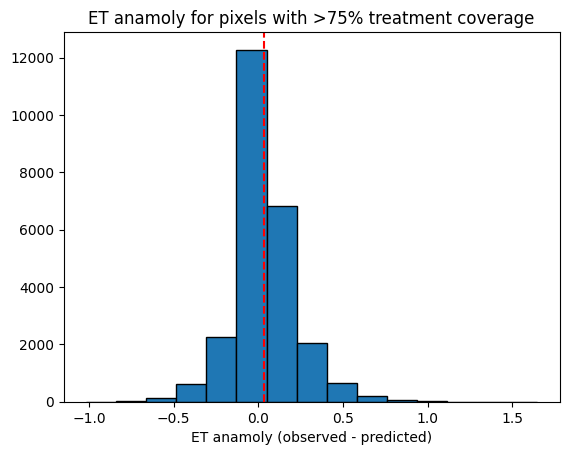

In [74]:
plt.hist(g75_anamoly, bins=15, edgecolor = 'black')
plt.xlabel('ET anamoly (observed - predicted)')
plt.axvline(g75_anamoly.mean(), color = 'red', linestyle = '--')
plt.title('ET anamoly for pixels with >75% treatment coverage')
print(g75_anamoly.mean())
plt.show()

In [28]:
bin_width = 0.2
bins = np.arange(g75_anamoly.min() - (g75_anamoly.min() % bin_width),
                 g75_anamoly.max() + bin_width,
                 bin_width)

plt.hist(g75_anamoly, bins=bins, edgecolor='black')

# Set x ticks at increments of 0.4 including 0
xmin, xmax = plt.xlim()
xticks = np.arange(np.floor(xmin / 0.4) * 0.4,
                   np.ceil(xmax / 0.4) * 0.4 + 0.001,
                   0.4)
plt.xticks(xticks)

# Add mean text on plot (you can adjust x,y position as needed)
plt.text(-1.1, 10000,
         f'Mean = {np.round(g75_anamoly.mean(),4)} mm/day')

plt.xlabel('ET anomaly (mm/day), observations - predictions')
plt.ylabel('# pixel-month pairs')
plt.axvline(g75_anamoly.mean(), color='red', linestyle='--')
plt.title('ET anomaly for pixels with >75% treatment coverage')
plt.show()


NameError: name 'g75_anamoly' is not defined

### 100% treated pixels

In [25]:
area_coverage = pd.read_csv('/scratch/users/ashdef/post_treatment_data/no_nans/pixel_treatment_withcover.csv')
area_coverage = area_coverage.drop(columns=["Unnamed: 0"])
area_coverage.head()

,nan_index,index,sfe_df_index,pixel_id,lat,lon,pixel_geometry,index_right,treatment_date,twig_categ,treatment_geometry,pixel_area,treatment_overlap
0,0,2190,116676,"(84, 252)",45.900000,-114.266667,POLYGON ((-12717787.98820922 5761006.692671617...,5439,1986-01-01,Mechanical,MULTIPOLYGON Z (((-12717456.6514 5760763.97770...,3.091471e+07,0.001432
1,1,6039,234246,"(169, 12)",42.358333,-124.266667,POLYGON ((-13830982.896141954 5211670.14706264...,46058,1986-01-01,Mechanical,POLYGON Z ((-13834012.5258 5218561.729099996 -...,2.911438e+07,0.001997
2,2,3344,152619,"(110, 159)",44.816667,-118.141667,POLYGON ((-13149151.015033154 5589436.68652023...,44196,1986-01-07,Mechanical,POLYGON Z ((-13154055.344700001 5588978.509900...,3.032842e+07,0.007198
3,3,10973,482615,"(348, 287)",34.900000,-112.808333,POLYGON ((-12555447.064135693 4147472.47688450...,23130,1986-02-01,Mechanical,POLYGON Z ((-12558898.384 4150060.4245000035 -...,2.623165e+07,0.026285
4,4,4535,184401,"(133, 63)",43.858333,-122.141667,POLYGON ((-13594428.978206249 5440329.27497087...,35229,1986-02-01,Mechanical Mechanical,MULTIPOLYGON Z (((-13598303.988699999 5443431....,2.983675e+07,0.003869


In [26]:
totalcover_indices = area_coverage[area_coverage['treatment_overlap'] == 1.0].index

pixel_treatment_totalcover = area_coverage.loc[totalcover_indices]
print(pixel_treatment_totalcover.shape)
pixel_treatment_totalcover.head()

(19, 13)


,nan_index,index,sfe_df_index,pixel_id,lat,lon,pixel_geometry,index_right,treatment_date,twig_categ,treatment_geometry,pixel_area,treatment_overlap
518,519,1226,73742,"(53, 284)",47.191667,-112.933333,POLYGON ((-12569362.000484854 5970003.13567984...,5,1989-01-01,"Mechanical, Unplanned Ignition",MULTIPOLYGON Z (((-12575269.2618 5957222.54999...,3.165919e+07,1.0
526,527,1194,72357,"(52, 285)",47.233333,-112.891667,POLYGON ((-12564723.688368468 5976828.72027862...,5,1989-01-01,"Mechanical, Unplanned Ignition",MULTIPOLYGON Z (((-12575269.2618 5957222.54999...,3.168408e+07,1.0
527,528,1193,72356,"(52, 284)",47.233333,-112.933333,POLYGON ((-12569362.000484854 5976828.72027862...,5,1989-01-01,"Mechanical, Unplanned Ignition",MULTIPOLYGON Z (((-12575269.2618 5957222.54999...,3.168408e+07,1.0
2136,2143,1155,70963,"(51, 277)",47.275000,-113.225000,POLYGON ((-12601830.185299557 5983659.66964649...,3198,2001-10-01,Unplanned Ignition,POLYGON Z ((-12608913.6174 5976916.526299998 -...,3.170901e+07,1.0
3390,3408,11136,493542,"(356, 126)",34.566667,-119.516667,POLYGON ((-13302215.314873906 4102331.71700451...,80555,2007-08-15,Unplanned Ignition,POLYGON Z ((-13302122.8889 4110774.1938999966 ...,2.612606e+07,1.0


In [27]:
prediction_arrays = np.load("/scratch/users/ashdef/model_out/6month_v3/post_treatment/prediction_arrays.npz", allow_pickle = True)["preds"]
sfe_arrays = np.load("/scratch/users/ashdef/model_out/6month_v3/post_treatment/sfe_arrays.npz", allow_pickle = True)["sfe"]

In [28]:
sfe_totcover_arrays = sfe_arrays[pixel_treatment_totalcover.index]
preds_totcover_arrays = prediction_arrays[pixel_treatment_totalcover.index]


In [29]:
sfe_totcover = sfe_totcover_arrays.reshape(-1)
preds_totcover = preds_totcover_arrays.reshape(-1)
print(sfe_totcover[10].shape)
preds_totcover[10].shape

(29,)


(29, 1)

In [30]:
for i in range(len(preds_totcover)):
    preds_totcover[i] = preds_totcover_arrays[i].flatten()
preds_totcover[10].shape

(29,)

In [31]:
sfe_totcover_pm = []
preds_totcover_pm = []

for pixel in range(len(sfe_totcover)):
    for t in range(len(sfe_totcover[pixel])):
        if len(sfe_totcover[pixel]) > 5:
            sfe_totcover_pm.append(sfe_totcover[pixel][t])
            preds_totcover_pm.append(preds_totcover[pixel][t])

In [32]:
sfe_totcover_pm = np.array(sfe_totcover_pm, dtype = object)
preds_totcover_pm = np.array(preds_totcover_pm, dtype = object)

In [33]:
np.savez_compressed('/scratch/users/ashdef/model_out/6month_v3/post_treatment/preds_totcover.npz', preds = preds_totcover_pm)
np.savez_compressed('/scratch/users/ashdef/model_out/6month_v3/post_treatment/sfe_totcover.npz', sfe = sfe_totcover_pm)

In [34]:
preds_totcover_pm_array = np.load('/scratch/users/ashdef/model_out/6month_v3/post_treatment/preds_totcover.npz', allow_pickle = True)["preds"]
sfe_totcover_pm_array = np.load('/scratch/users/ashdef/model_out/6month_v3/post_treatment/sfe_totcover.npz', allow_pickle = True)["sfe"]

In [35]:
obs = np.asarray(sfe_totcover_pm_array, dtype=np.float64).reshape(-1)
preds = np.asarray(preds_totcover_pm_array, dtype=np.float64).reshape(-1)

In [36]:
totcover_anamoly = obs - preds

In [37]:
totcover_anamoly = np.asarray(totcover_anamoly, dtype=np.float64).flatten()

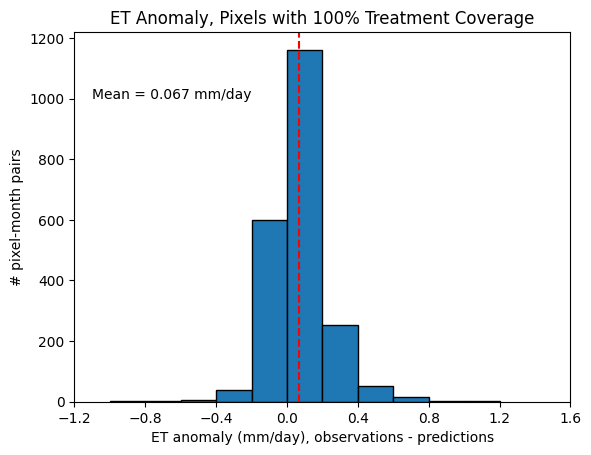

In [38]:
bin_width = 0.2
bins = np.arange(totcover_anamoly.min() - (totcover_anamoly.min() % bin_width),
                 totcover_anamoly.max() + bin_width,
                 bin_width)

plt.hist(totcover_anamoly, bins=bins, edgecolor='black')

# help from chatgpt for clean x ticks
xmin, xmax = plt.xlim()
xticks = np.arange(np.floor(xmin / 0.4) * 0.4,
                   np.ceil(xmax / 0.4) * 0.4 + 0.001,
                   0.4)
plt.xticks(xticks)

# Add mean text on plot (you can adjust x,y position as needed)
plt.text(-1.1, 1000, f'Mean = {np.round(totcover_anamoly.mean(),3)} mm/day')

plt.xlabel('ET anomaly (mm/day), observations - predictions')
plt.ylabel('# pixel-month pairs')
plt.axvline(totcover_anamoly.mean(), color='red', linestyle='--')
plt.title('ET Anomaly, Pixels with 100% Treatment Coverage')
plt.show()


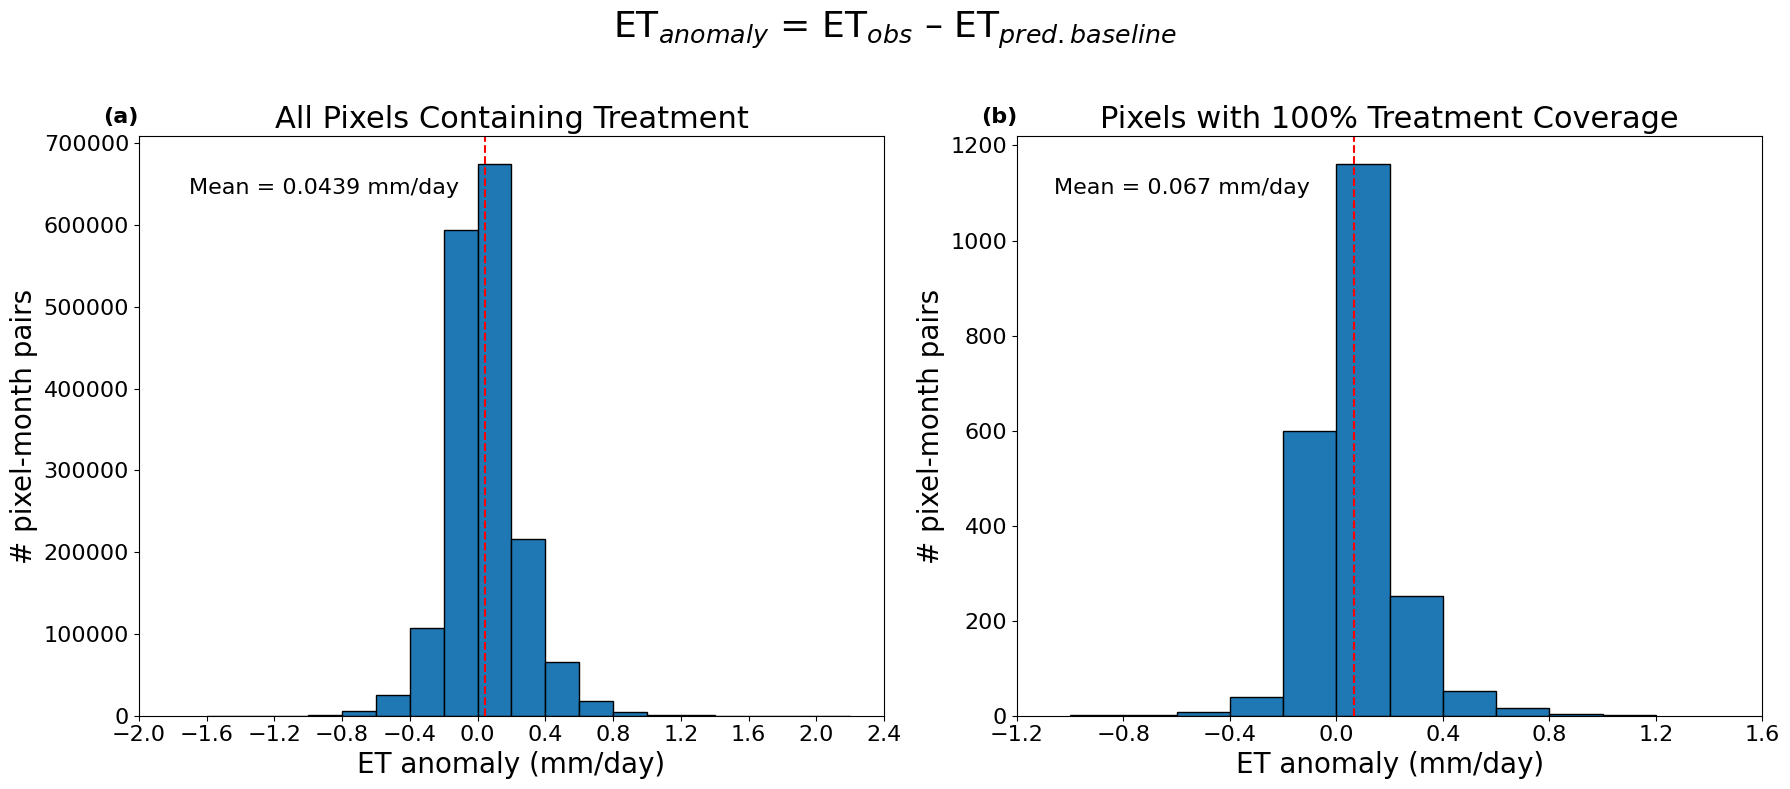

In [39]:
# asked chatgpt to combine prev plot with all pixel plot
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # wider and taller

bin_width_1 = 0.2
bins = np.arange(
    anamoly.min() - (anamoly.min() % bin_width_1),
    anamoly.max() + bin_width_1,
    bin_width_1
)

ax = axes[0]
ax.hist(anamoly, bins=bins, edgecolor='black')

xmin, xmax = ax.get_xlim()
xticks = np.arange(
    np.floor(xmin / 0.4) * 0.4,
    np.ceil(xmax / 0.4) * 0.4 + 0.001,
    0.4
)
ax.set_xticks(xticks)
ax.tick_params(labelsize = 16)

ax.axvline(anamoly.mean(), color='red', linestyle='--')
ax.text(xmin + 0.02*(xmax-xmin), max(ax.get_ylim())*0.9,
        f'Mean = {np.round(anamoly.mean(),4)} mm/day', fontsize = 16)

ax.set_xlabel('ET anomaly (mm/day)', fontsize = 20)
ax.set_ylabel('# pixel-month pairs', fontsize = 20)
ax.set_title('All Pixels Containing Treatment', fontsize = 22)
ax.text(0, 1.05, "(a)", transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

#bin_width_2 = 0.1
bins = np.arange(
    totcover_anamoly.min() - (totcover_anamoly.min() % bin_width_1),
    totcover_anamoly.max() + bin_width_1,
    bin_width_1
)

ax = axes[1]
ax.hist(totcover_anamoly, bins=bins, edgecolor='black')

xmin, xmax = ax.get_xlim()
xticks = np.arange(
    np.floor(xmin / 0.4) * 0.4,
    np.ceil(xmax / 0.4) * 0.4 + 0.001,
    0.4
)
ax.set_xticks(xticks)
ax.tick_params(labelsize = 16)

ax.axvline(totcover_anamoly.mean(), color='red', linestyle='--')
ax.text(xmin + 0.02*(xmax-xmin), max(ax.get_ylim())*0.9,
        f'Mean = {np.round(totcover_anamoly.mean(),3)} mm/day', fontsize = 16)

ax.set_xlabel('ET anomaly (mm/day)', fontsize = 20)
ax.set_ylabel('# pixel-month pairs', fontsize = 20)
ax.set_title('Pixels with 100% Treatment Coverage', fontsize = 22)
ax.text(0, 1.05, "(b)", transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')


fig.suptitle(r"ET$_{anomaly}$ = ET$_{obs}$ – ET$_{pred. baseline}$", fontsize=26)

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()